<a href="https://colab.research.google.com/github/arashfahim/Corporate-Governance-and-Asset-Pricing/blob/main/2D_LOB_Forward_Non_Linear_Coarse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Running cost

$\sum_{t=0}^{T-1}D_t\xi_t+\frac{\kappa}{2}\xi^{1+\alpha}_t$

Terminal cost

$D_T(R_0-\sum_{t=0}^{T-1}\xi_t)+\frac{\kappa}{2}(R_0-\sum_{t=0}^{T-1}\xi_t)^{1+\alpha}$

For $T=2$, the total loss is

$D_0\xi_0+\frac{\kappa}{2}\xi^{1+\alpha}_0+D_1(R_0-\xi_0)+\frac{\kappa}{2}(R_0-\xi_0)^{1+\alpha}$

$D_1=\rho(D_0+\kappa \xi_0^{\alpha})$

loss$=D_0\xi_0+\frac{\kappa}{2}\xi^{1+\alpha}_0+\rho(D_0+\kappa \xi_0^{\alpha})(R_0-\xi_0)+\frac{\kappa}{2}(R_0-\xi_0)^{1+\alpha}$

$=D_0\xi_0+\frac{\kappa}{2}\xi^{1+\alpha}_0+\rho D_0R_0-\rho D_0\xi_0+\rho R_0\kappa \xi_0^{\alpha}-\rho \kappa \xi_0^{1+\alpha}+\frac{\kappa}{2}(R_0-\xi_0)^{1+\alpha}$



$=\rho D_0R_0+D_0(1-\rho)\xi_0 + \frac{\kappa}{2}(R_0^2-2(1-\rho)\xi_0(R_0-\xi_0))=\rho D_0R_0+\frac{\kappa}{2}R_0^2+D_0(1-\rho)\xi_0 - {\kappa}(1-\rho)\xi_0(R_0-\xi_0)$

$(1-\rho){\kappa}\xi_0(\frac{D_0}{\kappa} - R_0+\xi_0)$


$\xi_0(\frac{D_0}{\kappa} - R_0+\xi_0)$

------------------------------

Minimization:


$\xi_0^*=\frac{R_0-\frac{D_0}{\kappa}}{2}=\frac{\kappa R_0-{D_0}{}}{2\kappa}$

-------------------------------

If $D_0=0$, $\xi_0=\frac{R_0}{2}$.

Total cost


$D_0\frac{\kappa R_0-D_0}{2\kappa}+\frac{\kappa}{2}\frac{(\kappa R_0-D_0)^2}{4\kappa^2}+D_1(R_0-\frac{\kappa R_0-D_0}{2\kappa})+\frac{\kappa}{2}(R_0-\frac{\kappa R_0-D_0}{2\kappa})^2$


If $D_0=0$, $\frac{\kappa}{4}(1+\rho)R_0^2$


In [189]:
import numpy as np
import json
from scipy import misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import random
import math
import pandas as pd
import cvxpy as cp
from scipy.optimize import fsolve
import time
import os

In [190]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [191]:
PATH = r"/content/gdrive/MyDrive/LOB_multi_scale_models/"

# New implementation for GPU

In [192]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [230]:
param_dict = {
        'M' : 100,# number of samples
        'T' : 10.0, # terminal time
        'iter' : 10, #number of steps minus terminal
        'kappa' : 1e-1, #price impact sensitivity factor
        'rho' : 1, #resillience<1
        'alpha' : 1.0, #price impact exponent
        'X0' : 1000
}

In [233]:
class exe_t(nn.Module):
    def __init__(self):
        super(exe_t, self).__init__()
        self.layer = torch.nn.Sequential()
        self.layer.add_module("L1",torch.nn.Linear(2, 20))#1d
        # self.layer.add_module("Tanh", torch.nn.Tanh())
        # self.layer.add_module("L2",torch.nn.Linear(20,40))
        # self.layer.add_module("Tanh", torch.nn.Tanh())
        # self.layer.add_module("L3",torch.nn.Linear(40,20))
        self.layer.add_module("Tanh", torch.nn.Tanh())
        self.layer.add_module("L4",torch.nn.Linear(20,1))
    def forward(self, tx):
        val = self.layer(tx)
        return val#torch.Tensor([0.5]).to(device)*tx[:,-1]#val

In [234]:
class opt_exe():#multi_step, optimal_control
    def __init__(self,params):
        self.M = params['M']# number of samples
        self.T= params['T'] # terminal time
        self.iter = params['iter'] #number of steps minus terminal
        self.Dt= torch.Tensor([self.T/self.iter]).to(device) #time step
        self.kappa=torch.Tensor([params['kappa']]).to(device) #price impact sensitivity factor
        self.rho=torch.exp(-params['rho']*self.Dt).to(device) #resillience<1
        self.alpha= params['alpha'] #price impact exponent
        self.X0=params['X0']
        self.D = torch.zeros([self.M,1]).to(device)
        self.R=torch.linspace(self.X0*0.85,self.X0*1.15,self.M).unsqueeze(-1).to(device)#torch.FloatTensor(self.M,1).uniform_(self.X0*0.95,self.X0*1.05).to(device)
        self.tx = torch.cat((self.D,self.R),axis=1)
        self.opt_path = torch.zeros([self.M,self.iter+1,3]).to(device)
        self.opt_exe = torch.zeros([self.M,self.iter+1]).to(device)
        self.models_t = [exe_t().to(device) for i in range(self.iter)]


    def unit(self,tx,model):
        exe_ = model(tx)# \xi(t,X_t) optimal strategy
        co_ = self.Dt*(tx[:,1]*exe_.squeeze(-1)+torch.Tensor([1/(1+self.alpha)]).to(device)*self.kappa *torch.pow(torch.abs(exe_.squeeze(-1)),1+self.alpha))
        up_ = torch.cat((self.rho*(tx[:,0].unsqueeze(-1)+self.Dt*self.kappa*torch.sign(exe_)*torch.pow(torch.abs(exe_),self.alpha)), tx[:,1].unsqueeze(-1)-exe_),axis=1)
        return exe_, co_, up_

    def loss(self):
        for i in range(self.iter):
            if i == 0:
                #X_0=(0,0,R_0)
                tx = self.tx
                # self.tx[:,i,:] = tx
                exe_, co_, up_ = self.unit(tx,self.models_t[i]) # \xi(0,X_0), running cost for X_0, X_{t_1}
                # print("exe:",exe_,"cost:",co_,"update:",up_)
                cost = co_ #record running cost
                # sum = exe_ # record executed order
                # print("price impact:", up_[:,1])
                # print("exe ",exe_)
            else:
                # self.tx[:,i,:] = up_
                exe_, co_, up_ = self.unit(up_,self.models_t[i]) # \xi(t_i,X_{t_i}), running cost for X_{t_i}, X_{t_{i+1}}
                cost = cost + co_ # add the running cost
                # sum = sum + exe_  # add the executed order to total
        # last step
        # print(up_)
        # self.tx[:,self.iter,:] = up_
        # print(self.R)
        # remain = self.R - sum # remaining balance carried to the last order
        # print(remain,up_[:,-1])
        cost = cost + self.Dt*(up_[:,1]*up_[:,-1]+torch.Tensor([1/(1+self.alpha)]).to(device)*self.kappa *torch.pow(torch.abs(up_[:,-1]),1+self.alpha)).squeeze(-1)   # cost of last order
        return torch.mean(cost)

    def approx_loss_2(self):
        for i in range(self.iter):
            if i == 0:
                self.opt_path[:,i,:] = torch.cat(((torch.Tensor([0.0]).repeat([self.M,1])).to(device),self.tx),axis=1)
                exe_, co_, up_ = self.unit(self.tx,self.models_t[i]) # \xi(0,X_0), running cost for X_0, X_{t_1}
                cost = co_ #record running cost
                # sum = exe_ # record executed order
                # print(exe_)
                self.opt_exe[:,i] = exe_.squeeze(-1)
            else:
                self.opt_path[:,i,:] = torch.cat((((self.Dt*i).repeat([self.M,1])),up_),axis=1)
                exe_, co_, up_ = self.unit(up_,self.models_t[i]) # \xi(t_i,X_{t_i}), running cost for X_{t_i}, X_{t_{i+1}}
                cost = cost + co_ # add the running cost
                # sum = sum + exe_  # add the executed order to total
                # print(exe_)
                self.opt_exe[:,i] = exe_.squeeze(-1)
        # last step
        self.opt_path[:,self.iter,:] = torch.cat((((self.Dt*self.iter).repeat([self.M,1])),up_),axis=1)
        # print(exe_)
        remain = up_[:,-1] # remaining balance carried to the last order
        self.opt_exe[:,self.iter] = remain
        cost = cost + self.Dt*(up_[:,1]*remain+torch.Tensor([1/(1+self.alpha)]).to(device)*self.kappa *torch.pow(torch.abs(remain),1+self.alpha))   # cost of last order
        return torch.mean(cost)#torch.cat((tx[:,-1].unsqueeze(-1),cost.unsqueeze(-1)),axis=1)


    def optimal_path(self,tx):
        M = tx.shape[0]
        opt_path = torch.zeros([M,self.iter+1,3]).to(device)
        opt_exe = torch.zeros([M,self.iter+1]).to(device)
        for i in range(self.iter):
            if i == 0:
                opt_path[:,i,:] = torch.cat(((torch.Tensor([0.0]).repeat([self.M,1])).to(device),self.tx),axis=1)
                exe_, co_, up_ = self.unit(tx,self.models_t[i]) # \xi(0,X_0), running cost for X_0, X_{t_1}
                cost = co_ #record running cost
                # sum = exe_ # record executed order
                # print(exe_)
                # print(i,":",exe_,",",up_[:,-1])
                opt_exe[:,i] = exe_.squeeze(-1)
            else:
                opt_path[:,i,:] = torch.cat((((self.Dt*i).repeat([self.M,1])),up_),axis=1)
                exe_, co_, up_ = self.unit(up_,self.models_t[i]) # \xi(t_i,X_{t_i}), running cost for X_{t_i}, X_{t_{i+1}}
                cost = cost + co_ # add the running cost
                # sum = sum + exe_  # add the executed order to total
                # print(i,":",exe_,",",up_[:,-1])
                opt_exe[:,i] = exe_.squeeze(-1)
        # last step
        opt_path[:,self.iter,:] = torch.cat((((self.Dt*self.iter).repeat([self.M,1])),up_),axis=1)
        # print(exe_)
        remain = up_[:,-1] # remaining balance carried to the last order
        # print("last: ",remain)
        opt_exe[:,self.iter] = remain
        cost = cost + self.Dt*(up_[:,1]*remain+torch.Tensor([1/(1+self.alpha)]).to(device)*self.kappa *torch.pow(torch.abs(remain),1+self.alpha))   # cost of last order
        return opt_path, opt_exe#torch.cat((tx[:,-1].unsqueeze(-1),cost.unsqueeze(-1)),axis=1)

    def visualize(self):
        self.approx_loss_2()
        ind = range(30,self.M-30,20)
        h = []
        l = []
        color = cm.rainbow(np.linspace(0, 1, len(ind)))
        fig, ax = plt.subplots(len(ind),1,figsize=(len(ind)*5,10),dpi=300)
        for i in range(len(ind)):
            ax[i].bar(self.opt_path[ind[i],:,0].cpu().detach().numpy(),self.opt_exe[ind[i],:].clone().detach().cpu().numpy(),label=r"$R_0$="+str(self.R[ind[i],0].detach().cpu().numpy()),color=color[i],width=0.5*p1.Dt.cpu().numpy())
            h_, l_ = ax[i].get_legend_handles_labels()
            h = h + h_
            l = l + l_

        ax[0].legend(h,l,loc='best',bbox_to_anchor=(1.0, 0.1, 0.2, 0.5));#, );
        plt.tight_layout();


In [235]:
p1 = opt_exe(param_dict)

**path to save the outcome**

In [236]:
od = p1.models_t[0].state_dict()
arch = '2D'
for key, value in od.items():
    if 'bias' in key:
        arch = "-".join([arch,str(value.shape[0])])
path = PATH+arch + '_alpha_' + str(p1.alpha)
if not os.path.exists(path):
    os.mkdir(path)
with open(path+"/params.json", "w") as outfile:
    json_object = json.dumps(param_dict, indent=4)
    outfile.write(json_object)

In [237]:
p1.models_t[0]

exe_t(
  (layer): Sequential(
    (L1): Linear(in_features=2, out_features=20, bias=True)
    (Tanh): Tanh()
    (L4): Linear(in_features=20, out_features=1, bias=True)
  )
)

In [238]:
# x = torch.linspace(p1.X0*0.85,p1.X0*1.15,10).to(device)
# y = p1.analytic_loss_1(x.unsqueeze(-1))[:,1].to(device)
# z = p1.analytic_loss_2(x.unsqueeze(-1))[:,1].to(device)
# plt.plot(x.cpu().clone().detach().numpy(),y.cpu().clone().detach().numpy(),label="analytic_1");
# plt.plot(x.cpu().clone().detach().numpy(),z.cpu().clone().detach().numpy(),label="analytic_2");
# plt.legend();

In [239]:
# p1.tx

In [240]:
p1.opt_path[:,0,:].shape, torch.cat(((torch.Tensor([0.0]).repeat([p1.M,1])).to(device),p1.tx),axis=1).shape

(torch.Size([100, 3]), torch.Size([100, 3]))

In [241]:
# p1.rho*(tx[:,1].unsqueeze(-1)+p1.Dt*self.kappa*torch.sign(exe_)*torch.pow(torch.abs(exe_),p1.alpha))

In [242]:
p1.optimal_path(p1.tx)[0].shape
# p1.optimal_path(p1.tx)[1].shape

torch.Size([100, 11, 3])

In [243]:
p1.approx_loss_2()

tensor(1058820.5000, device='cuda:0', grad_fn=<MeanBackward0>)

In [244]:
p1.loss()

tensor(1058820.5000, device='cuda:0', grad_fn=<MeanBackward0>)

In [245]:
parameters = list(p1.models_t[0].parameters())
for i in range(1,len(p1.models_t)):
    parameters = parameters + list(p1.models_t[i].parameters())
# parameters

In [246]:
lr1 = 1e-3
# lr2 = 1e-2
num_epochs = 10000
optimizer1 = optim.Adam(parameters, lr1)#,weight_decay=1e-2
# scheduler1 = lr_scheduler.LinearLR(optimizer1, start_factor=lr1, end_factor=lr2, total_iters=100)
L_ = torch.Tensor([-2000.0]).to(device)
cost = p1.loss()
loss_epoch = []
start=time.time()
err = 1e-8

In [247]:
epoch = 0
while (torch.abs(L_-cost)/torch.abs(L_)>err) &  (epoch <= num_epochs):#
    optimizer1.zero_grad()
    cost=p1.loss()
    cost.backward()
    optimizer1.step()
    #   before_lr = optimizer1.param_groups[0]["lr"]
    #   scheduler1.step()
    #   after_lr = optimizer1.param_groups[0]["lr"]
    loss_epoch.append(cost)
    if epoch>0:
        L_ = loss_epoch[epoch-1]
    if (epoch % 100==0):
        print("At epoch {} the cost is {}.".format(epoch,cost.detach()))
        # print("Epoch %d: SGD lr %.4f -> %.4f" % (epoch, before_lr, after_lr))
        # print("We are currently at cost {} versus analytic {}".format(p1.approx_loss_2(torch.Tensor([[0.0, 0.0, 10.0]]).to(device)),p1.analytic_loss_2(torch.Tensor([[10.0]]).to(device))))
    if  (torch.abs(L_-cost)/torch.abs(L_)<=err):
        print("Delta Loss = {} , epoch = {}".format(torch.abs(L_-cost)/torch.abs(L_),epoch))
        print("Final cost tally {}".format(p1.approx_loss_2(),cost))#,p1.analytic_loss_2(torch.Tensor([[10.0]]).to(device))
    epoch += 1
end=time.time()
print("Learning time: {}".format(end-start))

At epoch 0 the cost is 1058820.5.
At epoch 100 the cost is 1035697.875.
At epoch 200 the cost is 1013714.125.
At epoch 300 the cost is 992487.75.
At epoch 400 the cost is 971995.8125.
At epoch 500 the cost is 952217.875.
At epoch 600 the cost is 933132.75.
At epoch 700 the cost is 914721.6875.
At epoch 800 the cost is 896965.25.
At epoch 900 the cost is 879846.375.
At epoch 1000 the cost is 863347.1875.
At epoch 1100 the cost is 847451.75.
At epoch 1200 the cost is 832143.3125.
At epoch 1300 the cost is 817407.25.
At epoch 1400 the cost is 803228.6875.
At epoch 1500 the cost is 789593.3125.
At epoch 1600 the cost is 776487.3125.
At epoch 1700 the cost is 763897.875.
At epoch 1800 the cost is 751812.0.
At epoch 1900 the cost is 740217.25.
At epoch 2000 the cost is 729101.8125.
At epoch 2100 the cost is 718453.875.
At epoch 2200 the cost is 708262.375.
At epoch 2300 the cost is 698515.75.
At epoch 2400 the cost is 689203.8125.
At epoch 2500 the cost is 680316.0.
At epoch 2600 the cost is

In [248]:
p1.approx_loss_2()

tensor(556364.3125, device='cuda:0', grad_fn=<MeanBackward0>)

In [249]:
p1.opt_path[50,:,-1]

tensor([1001.5151,  909.4239,  817.6293,  725.3631,  633.4261,  541.7448,
         449.2708,  357.2714,  267.7858,  177.3499,   88.1910],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [250]:
p1.opt_exe[50,:]

tensor([92.0912, 91.7946, 92.2662, 91.9370, 91.6814, 92.4739, 91.9995, 89.4856,
        90.4358, 89.1590, 88.1910], device='cuda:0', grad_fn=<SliceBackward0>)

# **Saving the model**

In [251]:
od = p1.models_t[0].state_dict()
arch = '3D'
for key, value in od.items():
    if 'bias' in key:
        arch = "-".join([arch,str(value.shape[0])])
path = PATH+arch
if not os.path.exists(path):
    os.mkdir(PATH+arch)


In [252]:
for i in range(len(p1.models_t)):
    torch.save(p1.models_t[i].state_dict(),path+"/model"+str(i)+".pt")

In [253]:
pd.DataFrame(p1.tx.cpu().detach().numpy()).to_csv(path+"/optimal_path.csv", index=False)

# Visualization

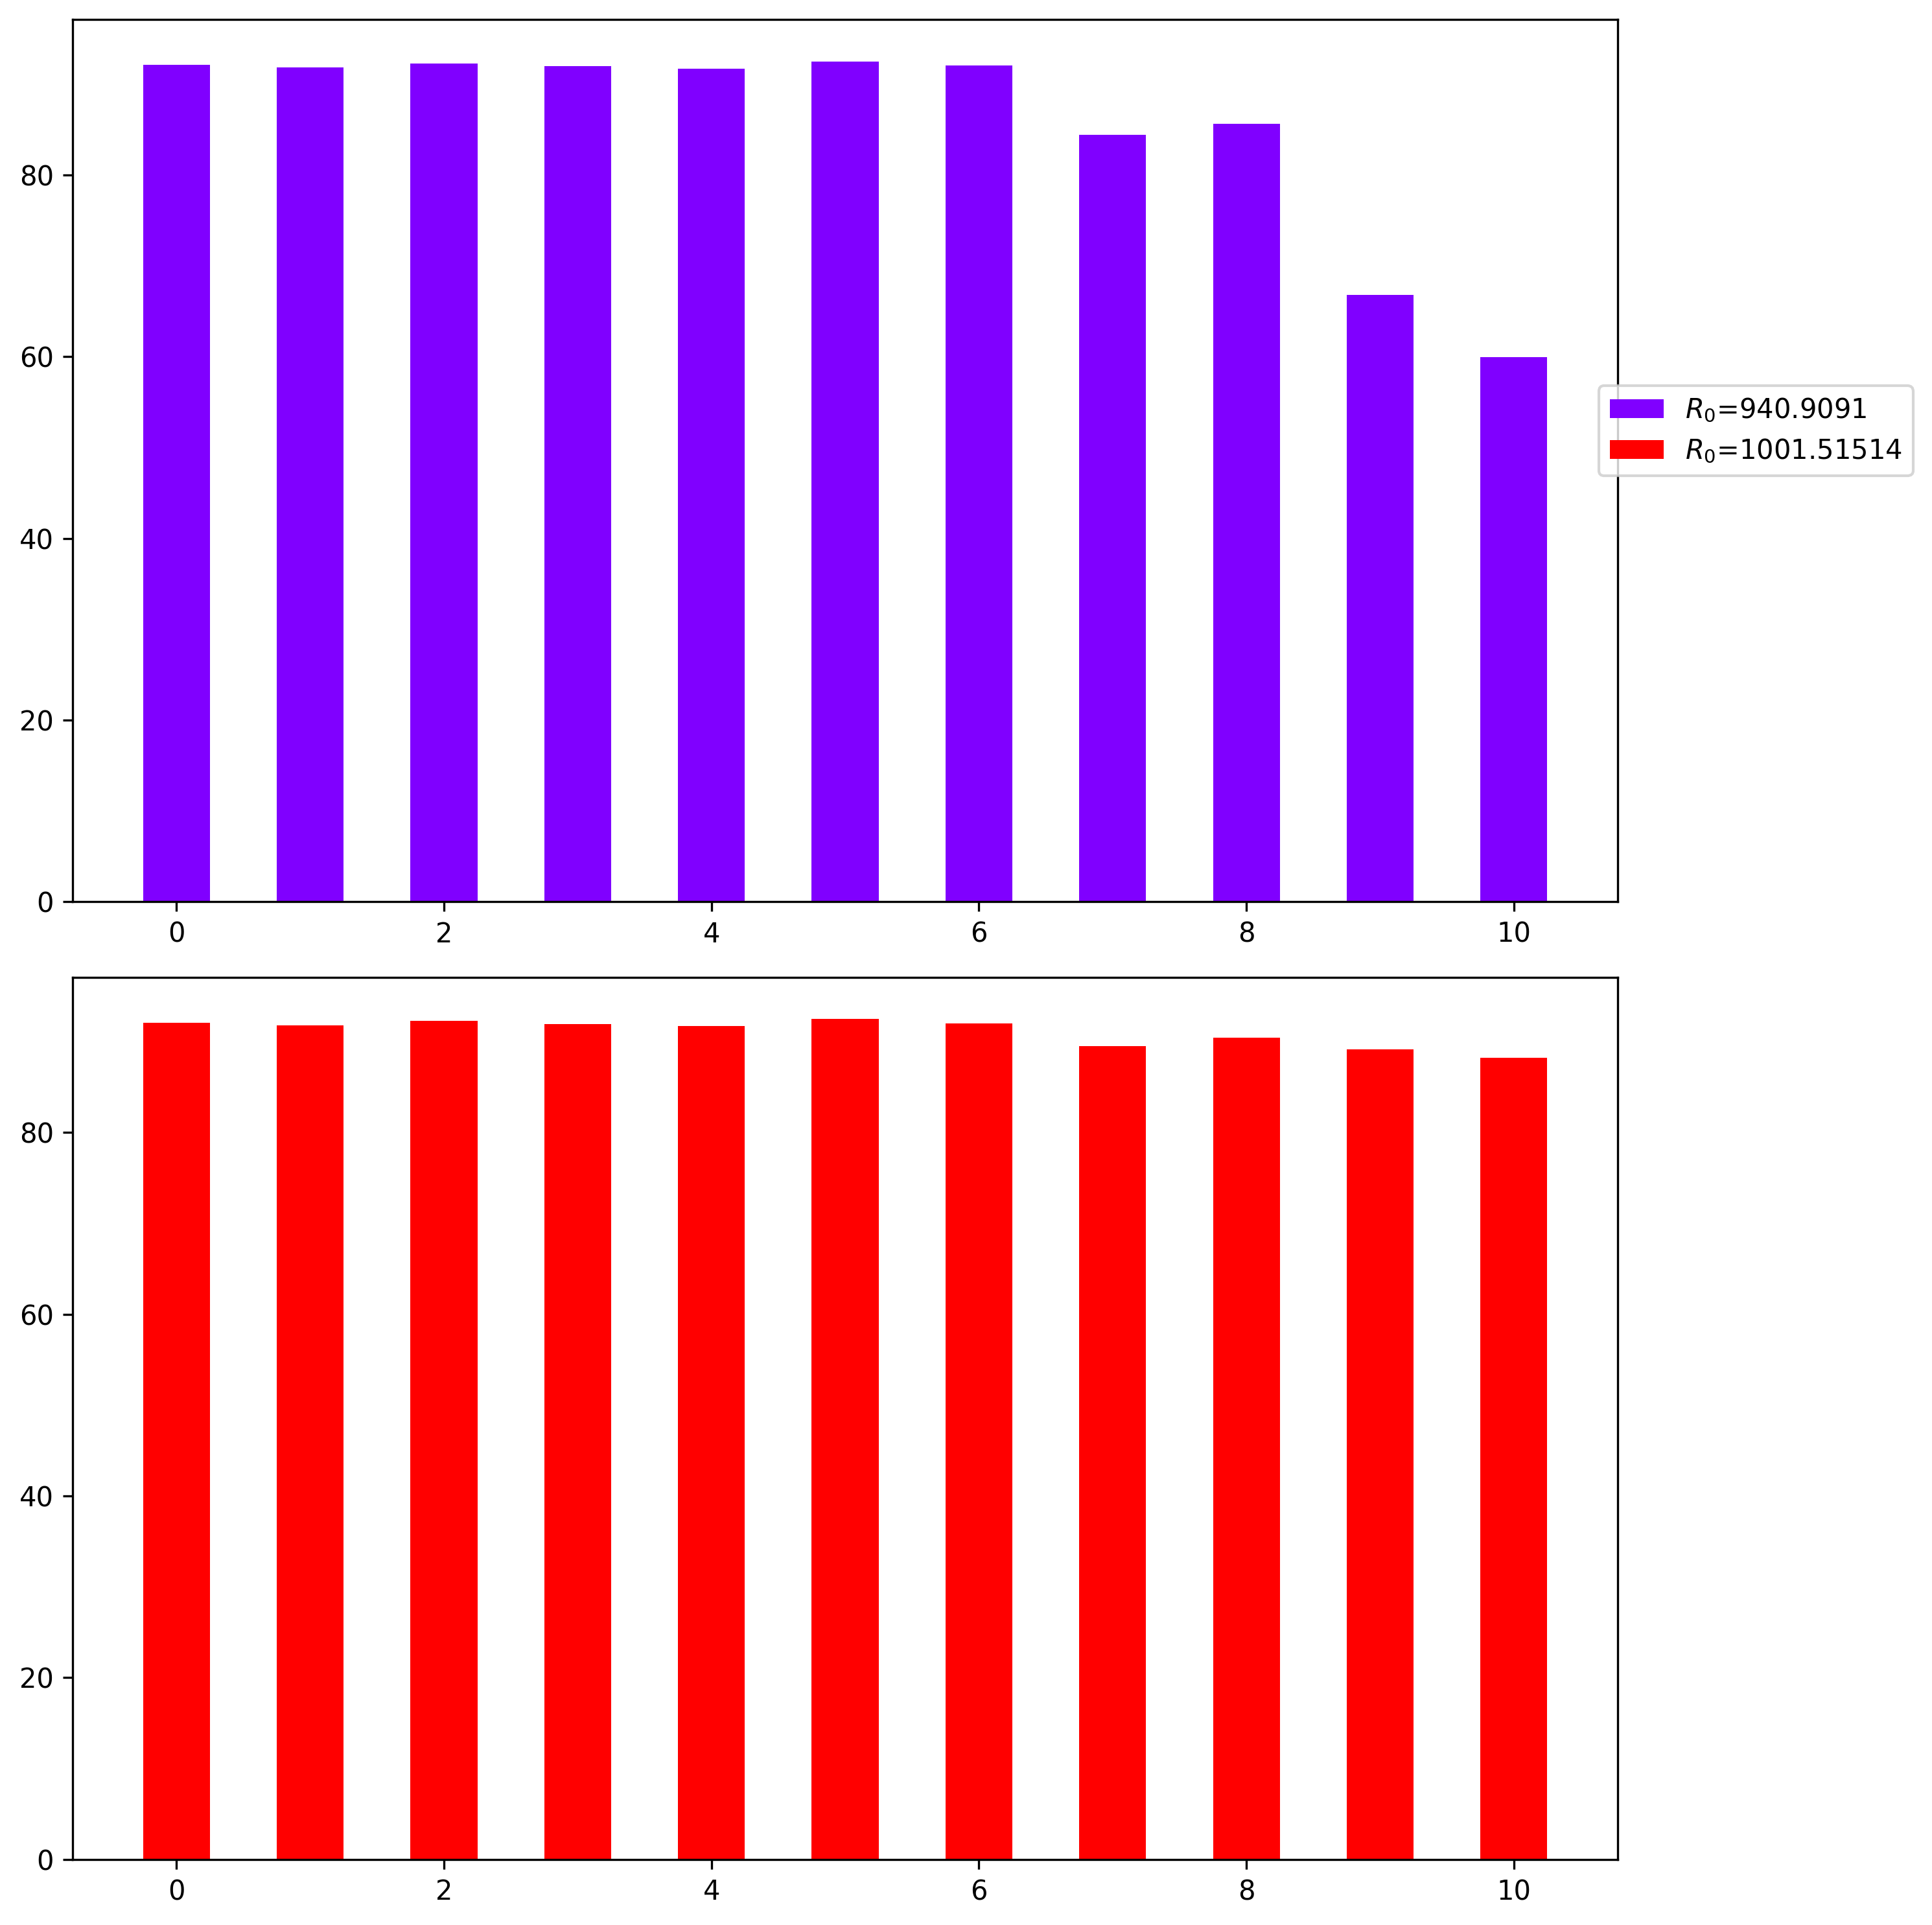

In [254]:
p1.visualize()
plt.savefig(path+"/plots.svg")

In [255]:
p1.opt_path

tensor([[[ 0.0000e+00,  0.0000e+00,  8.5000e+02],
         [ 1.0000e+00,  3.3878e+00,  7.5791e+02],
         [ 2.0000e+00,  4.6233e+00,  6.6611e+02],
         ...,
         [ 8.0000e+00,  5.0426e+00,  1.2223e+02],
         [ 9.0000e+00,  4.9700e+00,  3.7554e+01],
         [ 1.0000e+01,  3.3170e+00, -2.9111e+00]],

        [[ 0.0000e+00,  0.0000e+00,  8.5303e+02],
         [ 1.0000e+00,  3.3878e+00,  7.6094e+02],
         [ 2.0000e+00,  4.6233e+00,  6.6914e+02],
         ...,
         [ 8.0000e+00,  5.0426e+00,  1.2526e+02],
         [ 9.0000e+00,  4.9701e+00,  4.0581e+01],
         [ 1.0000e+01,  3.3173e+00,  1.0828e-01]],

        [[ 0.0000e+00,  0.0000e+00,  8.5606e+02],
         [ 1.0000e+00,  3.3878e+00,  7.6397e+02],
         [ 2.0000e+00,  4.6233e+00,  6.7217e+02],
         ...,
         [ 8.0000e+00,  5.0427e+00,  1.2828e+02],
         [ 9.0000e+00,  4.9701e+00,  4.3608e+01],
         [ 1.0000e+01,  3.3177e+00,  3.1248e+00]],

        ...,

        [[ 0.0000e+00,  0.0000e+00,  1